# Regression Project2 - RDD


#### Data Source:
    https://www.inspq.qc.ca/sites/default/files/covid/donnees/covid19-hist.csv
    
    
    https://www.inspq.qc.ca/covid-19/donnees

https://docs.google.com/presentation/d/1lHZUYHuypCQG8Md-NAMgIsBVxtQ92D6UHoOkQFX8zts/edit#slide=id.g20fc0d6daa5_0_36

## RDD Analysis

In [1]:
import os
import matplotlib.pyplot as plt 
import numpy as np 
from statsmodels.formula.api import ols
import pandas as pd
from patsy import dmatrices
import scipy.stats as sc
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats
import scipy.special

sns.set()

In [2]:
#    - COVID CASES -
df_cov = pd.read_csv('data/graph_1-1_page_par_region.csv')
df_cov

df_cov.rename({
    'Date de résultat du test':'Date',
    'Cas confirmés':'Cases',
}, axis=1, inplace=True)

df_cov['Date'] = pd.to_datetime(df_cov['Date'])


from datetime import datetime

# convert dates to days since 1970
def fromdate(x): return datetime.timestamp(x)/60/60/24

# convert columns to days (days since 1970, we'll subtract from it later to place it near zero)
df_cov['Date'] = df_cov['Date'].map(fromdate)


class event():
    def __init__(self, formula, feature, name, dates, offset_time = 14):
        
        self.formula=formula
        self.feature=feature
        self.name=name
        
        # convert all dates to days
        self.date=fromdate(datetime.strptime(dates[1],'%Y-%m-%d'))
        self.before=fromdate(datetime.strptime(dates[0],'%Y-%m-%d'))
        self.after=fromdate(datetime.strptime(dates[2],'%Y-%m-%d'))
        
        self.offset_time=offset_time
        
    def summary(self):
        return self.model.summary()

    def plot(self,ax,display_size = 6):
        
        lockdown = self.date  # date of the event, not relative time
        offset_time = self.offset_time # observation date, relative to event
        observation = lockdown + offset_time # observation date, not relative time
        before = self.before - observation  # fitting date start, relative to observation
        after = self.after - observation  # fitting date end, relative to observation
        
        df_cov2 = df_cov.copy()  # make a dataframe copy for relative time to offset_time days after the event
        
        # --------------------------------------------

        df_cov2['Date'] -= observation  # dataframe df_cov2 is relative to our observation date
        df_cov2 = df_cov2.loc[df_cov2['Date'] < after]  # remove before max date
        df_cov2 = df_cov2.loc[df_cov2['Date'] > before]  # remove after min date

        df_cov2[self.feature] = (df_cov2['Date'] > 0).astype(int)

        # --------------------------------------------

        df_cov3 = df_cov.copy()  # display

        df_cov3['Date'] -= observation  # dataframe df_cov3 is relative to our observation date
        df_cov3 = df_cov3.loc[df_cov3['Date'] < after*display_size]  # display_size times more data
        df_cov3 = df_cov3.loc[df_cov3['Date'] > before*display_size]

        # --------------------------------------------

        real_lockdown=-offset_time  # we'll draw a line when the real lockdown happened
        top = df_cov3['Cases'].max()
        ax.plot([real_lockdown, real_lockdown], [0, top], c='#888', alpha=1.0, linewidth=0.5, label=self.name)
        ax.plot([0, 0], [0, top], c='#000', alpha=1.0, linewidth=0.5, label='Two Week')

        # --------------------------------------------

        # both scatter and plot
        linewidth=0.5
        ax.scatter(df_cov3['Date'], df_cov3['Cases'], c='orange', alpha=1, s=2.5, label='Cases')
        ax.plot(df_cov3['Date'], df_cov3['Cases'], c='orange', alpha=1, linewidth=linewidth)

        # --------------------------------------------

        formula = self.formula 

        y, x = dmatrices(formula, df_cov2, return_type='dataframe')
        self.model = sm.OLS(y, x).fit()
        ax.plot(df_cov2['Date'], self.model.predict(x), c='blue', alpha=1.0, linewidth=1.0, label='Predict')
        ax.set_xlabel('Days')
        ax.set_ylabel('Cases')
        ax.tick_params(labelrotation=90)
        
        n_weeks = 6
        view_start=-7*n_weeks-offset_time
        view_end=7*n_weeks-offset_time
        
        ax.set_xticks(np.linspace(view_start,view_end,7))
        ax.set_xticklabels([f'Week {int((x+offset_time)/7)}' for x in np.linspace(view_start,view_end,7)])
        ax.tick_params(labelrotation=90)
        ax.legend(fancybox=True, framealpha=0.2)




## Model Summaries

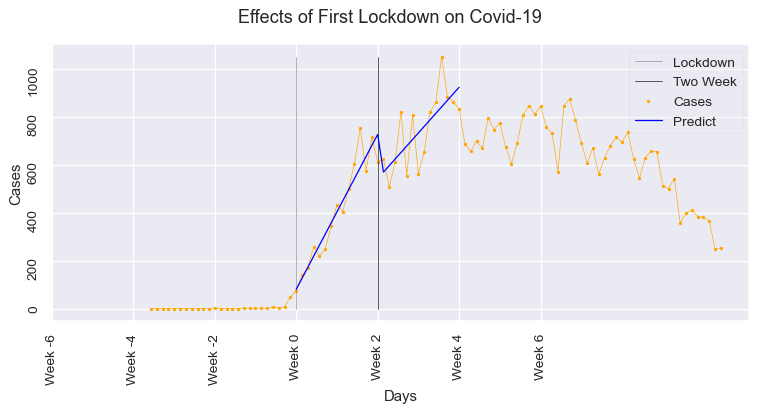

In [3]:
lockdown = event('''Cases ~ 
        Date
        + Lockdown
        + Lockdown:Date
    ''',
    feature='Lockdown',
    name = 'Lockdown',
    dates = [
        '2020-03-19',  # 
        '2020-03-20',  # lockdown
        '2020-04-18',  # 4 weeks after the event, 2 weeks after observation
    ],
    offset_time = 14
)

fig, (ax) = plt.subplots(1,1, figsize = (10,4), dpi = 90)
lockdown.plot(ax,display_size=4)
fig.suptitle('Effects of First Lockdown on Covid-19')
plt.show()

In [4]:
lockdown.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     60.65
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           1.30e-11
Time:                        10:27:36   Log-Likelihood:                -170.84
No. Observations:                  29   AIC:                             349.7
Df Residuals:                      25   BIC:                             355.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       726.6917     46.342     15.681      0.000     631.248     822.136
Date             46.1750      5.634      8.196      0.000      34.572      57.778
Lockdown       -184.5158     70.567     -2.615      0.015    -329.850     -39.181
Lockdown:Date   -18.9508      8.414     -2.252      0.033     -36.280      -1.621
==============================================================================
Omnibus:                        1.531   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.465   Jarque-Bera (JB):                0.919
Skew:                           0.436   Prob(JB):                        0.632
Kurtosis:                       3.034   Cond. No.                         43.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### All p-values are significant at 95% confidence (P<0.05)

#### A strong impact of the lockdown on Covid-19 cases is seen instantly through the significant p-value (P<0.05) of Lockdown.

#### A strong impact of the lockdown on Covid-19 cases is seen over time through the significant p-value (P<0.05) of Lockdown:Date combined.

#### This demonstrates that there was a significant effect of the first lockdown in March 2020 on the number of Covid-19 cases.

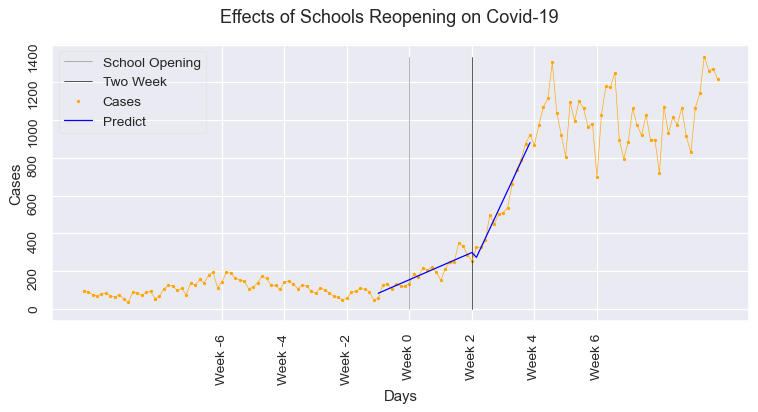

In [5]:

schools = event('''Cases ~ 
        Date
        + School
        + School:Date
    ''',
    feature='School',
    name='School Opening',
    dates=[
        '2020-08-23', # 1 week before the event, 3 weeks before observation
        '2020-08-31',
        '2020-09-28', # 4 weeks after the event, 2 weeks after observation
    ])

fig, (ax) = plt.subplots(1, 1, figsize = (10,4), dpi = 90)
schools.plot(ax, display_size=4)
fig.suptitle('Effects of Schools Reopening on Covid-19')
plt.show()

In [6]:
schools.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     364.6
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           3.00e-24
Time:                        10:27:47   Log-Likelihood:                -176.98
No. Observations:                  35   AIC:                             362.0
Df Residuals:                      31   BIC:                             368.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     297.9368     16.646     17.898      0.000     263.987     331.887
Date           10.2970      1.357      7.589      0.000       7.530      13.064
School        -76.5906     29.007     -2.640      0.013    -135.752     -17.430
School:Date    40.4228      3.286     12.301      0.000      33.721      47.125
==============================================================================
Omnibus:                        0.346   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.841   Jarque-Bera (JB):                0.080
Skew:                          -0.117   Prob(JB):                        0.961
Kurtosis:                       3.004   Cond. No.                         50.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### All p-values are significant at 95% confidence (P<0.05)

#### A strong impact of the lockdown on Covid-19 cases is seen instantly through the significant p-value (P<0.05) of School.

#### A strong impact of the lockdown on Covid-19 cases is seen over time through the significant p-value (P<0.000) of School:Date combined.

#### This demonstrates that there was a significant effect of schools reopening in August 2020 on the number of Covid-19 cases. 


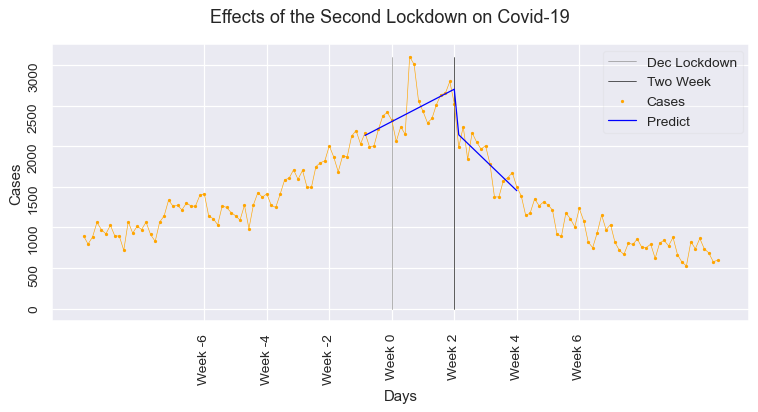

In [7]:

lockdown2 = event('''Cases ~ 
        Date
        + Lockdown
        + Date:Lockdown
    ''',
    feature='Lockdown',
    name='Dec Lockdown',
    dates=[
        '2020-12-18', # 1 week before the event, 3 weeks before observation
        '2020-12-25',
        '2021-01-23', # 4 weeks after the event, 2 weeks after observation
    ])

fig, (ax) = plt.subplots(1, 1, figsize = (10, 4), dpi = 90)
lockdown2.plot(ax, display_size=4)
fig.suptitle('Effects of the Second Lockdown on Covid-19')
plt.show()

In [8]:
lockdown2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     28.77
Date:                Fri, 24 Feb 2023   Prob (F-statistic):           4.34e-09
Time:                        10:27:51   Log-Likelihood:                -237.64
No. Observations:                  35   AIC:                             483.3
Df Residuals:                      31   BIC:                             489.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2704.0303     96.266     28.089      0.000    2507.694    2900.366
Date             28.4935      8.235      3.460      0.002      11.699      45.288
Lockdown       -509.1292    160.954     -3.163      0.003    -837.398    -180.861
Date:Lockdown   -81.4517     17.243     -4.724      0.000    -116.619     -46.285
==============================================================================
Omnibus:                       11.873   Durbin-Watson:                   1.331
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.061
Skew:                           1.082   Prob(JB):                      0.00240
Kurtosis:                       4.895   Cond. No.                         49.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### All p-values are significant at 95% confidence (P<0.05)

#### A strong impact of the lockdown on Covid-19 cases is seen instantly through the significant p-value (P<0.05) of Lockdown.

#### A strong impact of the lockdown on Covid-19 cases is seen over time through the significant p-value (P<0.000) of Lockdown:Date combined.

#### This demonstrates that the second lockdown in December 2020 had a significant impact on the number of Covid-19 cases. 


## Justifications

No polynomial features added to the RDD model as they did not allow for accurate interpretation of the data as seen by the p-values, no polynomial features we tried to add were statistically significant. 

First lockdown, the time starts at the event and ends four weeks after the event.

For the schools opening, it starts one week before the event and end four weeks after the event.

For the second lockdown, it starts one week before the event and ends four weeks after the event.

The one week before is to establish the pre-event baseline, except for the first lockdown as there is a lack of data. The four week time period post-events is to allow time for incubation periods and time to get tested for Covid-19.

## Two paragraph explanation 

We performed a RDD analysis on data collected on Covid-19 cases in Quebec, Canada during 2020. The three significant events used in the analysis were the first lockdown in March, the schools reopening in August, and the second lockdown in December. All of the events caused a significant change in the number of recorded Covid-19 cases.


The first lockdown showed a sharp significant (P<0.05) decrease in the number of cases two weeks after it started, followed by a significant decrease in cases over time (Date:Lockdown). The schools reopening causes a significant increase (P<0.05) in the number of cases over time. There was an immediate decreases in cases we can't explain. Finally, the second lockdown caused a significant decrease (P<0.05) in the number of Covid-19 cases and cases over time.

